#<small> <i>Task 7. </small> </i> Study an integral
# * <big> $ S = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx$ </big>, where $a = 5$ and $b = 7$
1. Compute analytically the value of $S$
2. Provide a parallel numerical computation of the integral $S$ using, for example, the trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$
  * The number of MPI processes $n_p$ does not depend on the number of discretization points $N$, i.e., $n_p \ne N$ in general. 
  * Use <strong>Reduce </strong> function of <i>mpi4py </i> to sum across processes.
3. Plot the speedup $s(n_p)$ for a parallel version of program for different number of processes $n_p$. The speedup is determined by $s(n_p) = \displaystyle \frac{t_p(n_p)}{t_s}$, where $t_s$ and $t_p(n_p)$ are computational times of sequential and parallel versions of program.
4. Plot the error value $e(\tau) = |S_D(\tau) - S| $ versus discretization step graph $\tau$ by varying number of discretization steps $N$.

<b> Bonus task. </b> 
* Implement the Monte Carlo method and compare with the trapezoidal method in terms of errors. 
* When the Monte Carlo method works better than the trapezoidal one?

### T7.1 	Analytical computation of the integral is given.

# $ \displaystyle \ln \displaystyle |{\sqrt{1 + x^2} + x}| + C $

apply Neqton-Leibniz formula F(b) - F(a)

ln(sqrt(50)+7) - ln(sqrt(26)+5) = 0.331

### T7.2 	Trapezoidal approximation is used.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Integration_num_trapezes_notation.svg/1920px-Integration_num_trapezes_notation.svg.png)


#### Check trapezoidal functions and calculate time of executing in serial

In [1]:
import numpy as np

# optimized
def trapezoidal(f, a, b, n):
    h = float(b - a) / n
    s = 0.0
    s += f(a)/2.0
    for i in range(1, n):
        s += f(a + i*h)
    s += f(b)/2.0
    return s  * h

%timeit trapezoidal(lambda x: (1 / (np.sqrt(1+x**2))), 5, 7, 100)
print(trapezoidal(lambda x: (1 / (np.sqrt(1+x**2))), 5, 7, 100))

The slowest run took 9.92 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 164 µs per loop
0.33168301697301306


In [2]:
# non-optimized
def trapezoidal2(f, a, b, n):
    h = float(b - a) / n
    s = 0.0
    for i in range(1, n):
        s += h * (f(a + i*h) + f(a + (i-1)*h))/2.0
    return s

print(trapezoidal2(lambda x: (1 / (np.sqrt(1+x**2))), 5, 7, 100))
t_seq = %timeit -o trapezoidal2(lambda x: (1 / (np.sqrt(1+x**2))), 5, 7, 100)
t_seq.best

0.32885061904581886
1000 loops, best of 3: 358 µs per loop


0.0003580805419999962

#### Calculate integral using sum-reduce

In [29]:
%%file trapezoidal.py

from mpi4py import MPI
import numpy as np

# non-optimized
def trapezoidal2(f, a, b, n):
    h = float(b - a) / n
    s = 0.0
    for i in range(1, n):
        s += h * (f(a + i*h) + f(a + (i-1)*h))/2.0
    return s

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

t1 = MPI.Wtime()

a = 5.0
b = 7.0
n_chanks = 1000000

milestones = np.linspace(a, b, n_chanks+1)
# if rank == 0:
#     print("milestones are: ", milestones)
#     print(" ")

# if n_chanks % size == 0:                       # check that work is allocated equally

my_n_chanks = int(n_chanks / size)         # how many chanks each worker gets
my_start_index = rank * my_n_chanks
my_end_index = (rank+1) * my_n_chanks

my_start = milestones[my_start_index]
my_end = milestones[my_end_index]

if rank == 0:
    recvbuf = np.zeros(1, dtype="float64")
else:
    recvbuf = None

sendbuf = trapezoidal2(lambda x: (1 / (np.sqrt(1+x**2))), 
                        my_start, 
                        my_end, 
                        my_n_chanks)

comm.Reduce(sendbuf, recvbuf, op = MPI.SUM, root = 0)

TIME = comm.gather((MPI.Wtime() - t1), root=0)
if not rank:
    print(np.sum(TIME)/size)

if rank == 0:
    print("recvbuf = %r" % recvbuf[0])

Overwriting trapezoidal.py


In [25]:
t = !mpiexec --allow-run-as-root -n 1 python -m mpi4py trapezoidal.py
float(t[0])

0.007221739999295096

In [26]:
t = !mpiexec --allow-run-as-root -n 2 python -m mpi4py trapezoidal.py
float(t[0])

0.034405025499836484

In [31]:
!mpiexec --allow-run-as-root -n 1 python -m mpi4py trapezoidal.py

6.032167115999982
recvbuf = 0.33168213694314613


### T7.3 	We can arbitrarily choose the number of MPI processes that we want to launch and it does not depend on the number of discretization points.

### T7.4 	Speedup versus number of processors graph is plotted.

1 loop, best of 3: 3.65 s per loop
seqential best time:  3.649052685999777
parallalized:  6.0071367119999195
parallalized:  6.186820013500437


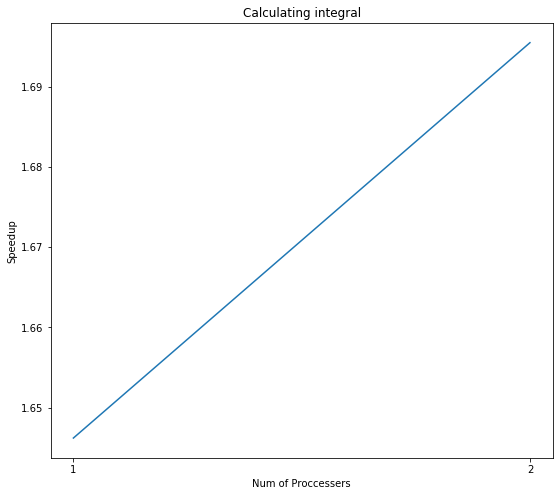

In [33]:
t_seq = %timeit -o trapezoidal2(lambda x: (1 / (np.sqrt(1+x**2))), 5.0, 7.0, 1000000)
t_seq.best
print("seqential best time: ", t_seq.best)

time = np.zeros(2, dtype="float64")
speedup = np.zeros(2, dtype="float64")

processors = [1, 2]

for team_size in processors:
    t = !mpiexec --allow-run-as-root -n {team_size} python -m mpi4py trapezoidal.py
    print("parallalized: ", t[0])
    time[team_size-1] = float(t[0])
    speedup[team_size-1] = float(t[0]) / t_seq.best

plt.figure(figsize=(9,8))
plt.plot(processors, speedup)
plt.ylabel('Speedup')
plt.xticks([1,2])
plt.xlabel('Num of Proccessers')
plt.title('Calculating integral')
# plt.legend()
plt.show()

### T7.5 	Error value versus discretization step graph is plotted.

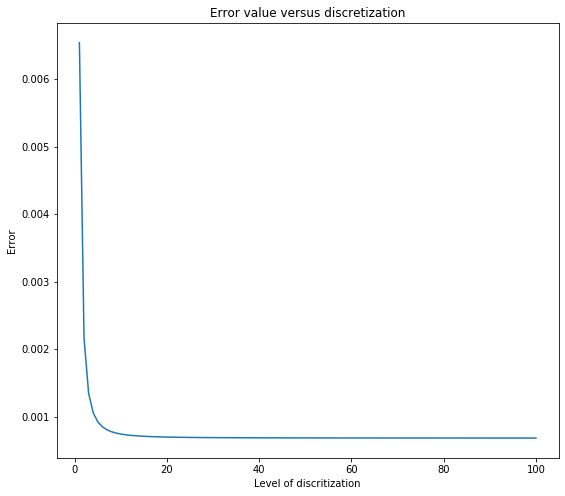

In [8]:
import numpy as np

# optimized
def trapezoidal(f, a, b, n):
    h = float(b - a) / n
    s = 0.0
    s += f(a)/2.0
    for i in range(1, n):
        s += f(a + i*h)
    s += f(b)/2.0
    return s  * h

errors = []
analytical = 0.331
discretizations = range(1, 101)

for level in discretizations:
    numerical = trapezoidal(lambda x: (1 / (np.sqrt(1+x**2))), 5, 7, level)
    errors.append(abs(analytical - numerical))

plt.figure(figsize=(9,8))
plt.plot(discretizations, errors) #, label='parallization')
# plt.plot(range(1,7), TIME1, label='no parallization')
plt.ylabel('Error')
plt.xlabel('Level of discritization')
plt.title('Error value versus discretization')
# plt.legend()
plt.show()